In [1]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import glob
import pandas as pd
import numpy as np
import py2edw
import datetime as dt
import time

import operator

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.cm as cm
import seaborn as sns

# Read in Data

In [2]:
path = r'C:\Users\wkong\Desktop\Work\customer_segmentation\data\clean'
files = glob.glob(path + '/*.csv')

In [3]:
data = pd.read_csv(os.path.join(path,'prepped_customer_data.csv'))
data.set_index('customer_id', inplace=True)
data_df = pd.DataFrame(data)

# Scale Data

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# DBSCAN

In [5]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [6]:
def plot_clusters(data, labels, core_samples_mask, fname, show_outliers=False):
    unique_labels = set(labels)
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
    
    fig = plt.figure(figsize=(22,20))
    plt.subplots_adjust(hspace=0.2)
    ctr=0
    for i in range(len(data[0])-1):
        ax = fig.add_subplot(7, 3, i+1) 
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]
            class_member_mask = (labels == k)

            xy = pd.DataFrame(data[class_member_mask & core_samples_mask])
            plt.plot(xy.iloc[:, i], xy.iloc[:, i+1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14, label=k)    
            plt.xlabel(i)
            plt.ylabel(i+1)

            if show_outliers:
                xy = pd.DataFrame(data[class_member_mask & ~core_samples_mask])
                plt.plot(xy.iloc[:, i], xy.iloc[:, i+1], 'o', markerfacecolor=tuple(col),
                         markeredgecolor='k', markersize=2, label=k)
            
            plt.xlabel('PCA{}'.format(i),labelpad=10)
            plt.ylabel('PCA{}'.format(i+1))
            plt.tight_layout()
    
    plt.legend(ncol=15, loc='lower center', bbox_to_anchor=(0.5, -0.5))
    
    if fname:
        plt.savefig("{}.jpg".format(fname),  format='jpg', dpi=200)

In [7]:
dataDB = PCA(n_components=22, svd_solver='full').fit_transform(X_scaled)

In [10]:
def run_dbscan(dataDB, data_df, eps, min_samples, fname, showplot, showoutliers):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(dataDB)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('Estimated number of clusters: %d' % n_clusters_)
    
    if showplot:
        plot_clusters(dataDB, labels, core_samples_mask, fname, showoutliers)
    
    label_df = pd.DataFrame(labels)
    label_df.columns = ['label']
    
    res_df = pd.concat([data_df.reset_index(),label_df], axis=1)
    if fname:
        res_df.to_csv(fname, index=False)
    display(res_df.groupby('label').agg({'customer_id':'count'}))    

In [9]:
for eps in tqdm([0.01, 0.1, 1, 10]):
#for eps in tqdm([10]):
    for min_samples in tqdm([3,5,8,16,32,64]):
        print('eps = {}, min_samples = {}'.format(eps, min_samples))
        fname = 'DBSCAN_eps-{}_ms-{}_results.csv'.format(eps,min_samples)
        run_dbscan(dataDB, data_df, eps, min_samples, fname, False)

eps = 10, min_samples = 3
Estimated number of clusters: 3


,customer_id
label,
-1,154
0,32168
1,3
2,3


eps = 10, min_samples = 5
Estimated number of clusters: 1


,customer_id
label,
-1,163
0,32165


eps = 10, min_samples = 8
Estimated number of clusters: 1


,customer_id
label,
-1,175
0,32153


eps = 10, min_samples = 16
Estimated number of clusters: 1


,customer_id
label,
-1,187
0,32141


eps = 10, min_samples = 32
Estimated number of clusters: 1


,customer_id
label,
-1,207
0,32121


eps = 10, min_samples = 64
Estimated number of clusters: 1


,customer_id
label,
-1,219
0,32109


# Final Run

Estimated number of clusters: 5


,customer_id
label,
-1,5804
0,26503
1,5
2,4
3,7
4,5


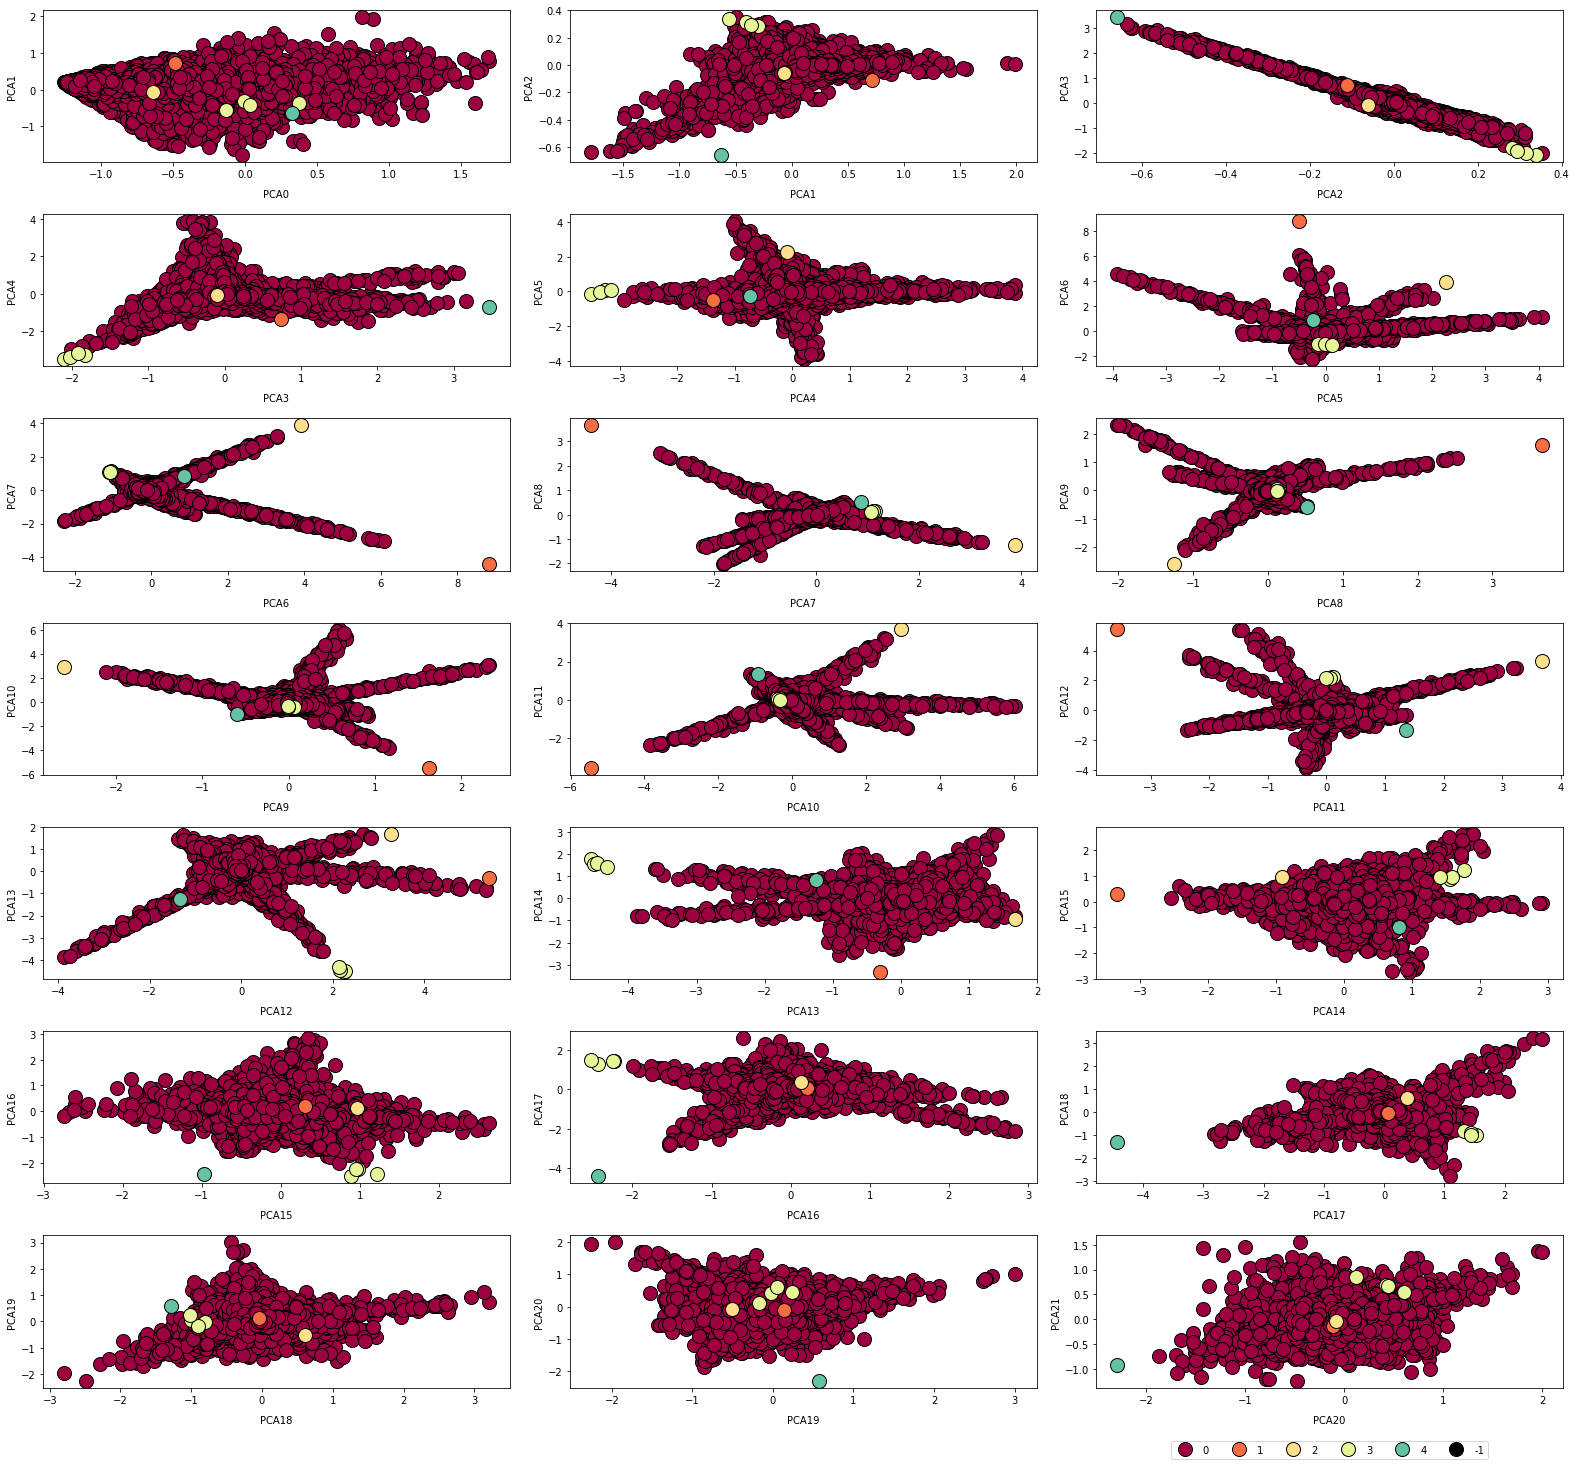

In [12]:
eps = 1
min_samples = 5
fname = 'DBSCAN_eps-{}_ms-{}_results.csv'.format(eps,min_samples)
run_dbscan(dataDB, data_df, eps, min_samples, fname, True, False)